In valid start node or in Obstacle space
In valid goal node or in Obstacle space
not found


NameError: name 'x_path' is not defined

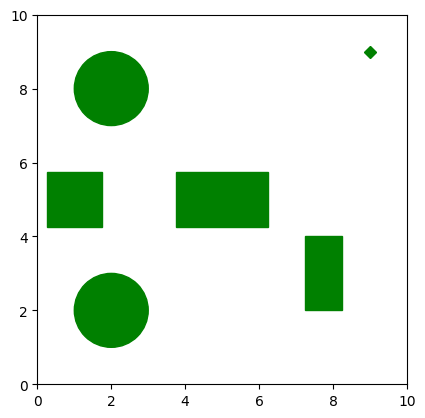

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import heapq
from math import dist
import matplotlib.patches as patches

plt.ion()

class Node:

    def __init__(self, x, y, parent,current_theta, change_theta,UL,UR, c2c, c2g, total_cost ):
        self.x = x
        self.y = y
        self.parent = parent
        self.current_theta = current_theta
        self.change_theta = change_theta
        self.UL = UL
        self.UR = UR
        self.c2c = c2c
        self.c2g = c2g
        self.total_cost = total_cost 
        
    def __lt__(self,other):
        return self.total_cost < other.total_cost


#### Function to plot dubins curves ####
def plot_curve(Xi, Yi, Thetai, UL, UR,c, plot, Nodes_list, Path_list):
    t = 0
    r = 0.038
    L = 0.354
    dt = 0.1
    cost = 0
    Xn = Xi
    Yn = Yi
    Thetan = 3.14 * Thetai / 180

    # Xi, Yi,Thetai: Input point's coordinates
    # Xs, Ys: Start point coordinates for plot function
    # Xn, Yn, Thetan: End point coordintes

    while t < 1:
        t = t + dt
        Xs = Xn
        Ys = Yn
        Xn += r*0.5 * (UL + UR) * math.cos(Thetan) * dt
        Yn += r*0.5 * (UL + UR) * math.sin(Thetan) * dt
        Thetan += (r / L) * (UR - UL) * dt
        # plt.plot([Xs, Xn], [Ys, Yn], color="blue")
        if  Valid_move(Xn, Yn, r, c):
            if plot == 0:
                # plt.plot([Xs, Xn], [Ys, Yn], color="blue")
                c2g = dist((Xs, Ys), (Xn, Yn))
                cost = cost + c2g
                Nodes_list.append((Xn, Yn))
                Path_list.append((Xs, Ys))
            if plot == 1:
                plt.plot([Xs, Xn], [Ys, Yn], color="red")
        else:
            return None
    Thetan = 180 * (Thetan) / 3.14
    return [Xn, Yn, Thetan, cost, Nodes_list, Path_list]

######### GENERATE UNIQUE KEY ##########

def key(node):
    key = 1022*node.x + 111*node.y 
    return key

### Function to implement A star ########
def Astar_algorithm(start_node, goal_node,rpm1,rpm2,r,clearance):

    if check_goal(start_node, goal_node):
        return 1,None,None
    
    start_node = start_node
    start_node_id = key(start_node)
    goal_node = goal_node

    Nodes_list = []
    Path_list = []
    
    explored_nodes = {}
    unexplored_nodes = {}
    
    unexplored_nodes[start_node_id] = start_node
    
    
    priority_list = []
    
    moves = [[rpm1, 0], 
             [0, rpm1], 
             [rpm1, rpm1], 
             [0, rpm2], 
             [rpm2, 0], 
             [rpm2, rpm2], 
             [rpm1, rpm2],
             [rpm2, rpm1]]
    
    heapq.heappush(priority_list, [start_node.total_cost, start_node])

    while (len(priority_list) != 0):

        present_node = (heapq.heappop(priority_list))[1]
        current_id = key(present_node)

        if check_goal(present_node, goal_node):
            goal_node.parent = present_node.parent
            goal_node.total_cost = present_node.total_cost
            print("Goal Node found")
            return 1,Nodes_list,Path_list
        
        if current_id in explored_nodes:  
            continue
        else:
            explored_nodes[current_id] = present_node
        
        del unexplored_nodes[current_id]
        

        for move in moves:
            X1 = plot_curve(present_node.x, present_node.y, present_node.current_theta, move[0], move[1],
                            clearance, 0, Nodes_list, Path_list)
           
            
            if (X1 != None):
                angle = X1[2]
                
                theta_threshold = 15
                x = (round(X1[0] * 10) / 10)
                y = (round(X1[1] * 10) / 10)
                th = (round(angle / theta_threshold) * theta_threshold)
                ct = present_node.change_theta - th
                
                c2g = dist((x,y), (goal_node.x, goal_node.y))
                new_node = Node(x,y,present_node,th,ct,move[0],move[1],present_node.c2c+X1[3],c2g,present_node.c2c+X1[3]+c2g)

                new_node_id = key(new_node)

                if not Valid_move(new_node.x, new_node.y,r,clearance):
                    continue
                elif new_node_id in explored_nodes:
                    continue
                if new_node_id in unexplored_nodes:
                    if new_node.total_cost < unexplored_nodes[new_node_id].total_cost:
                        unexplored_nodes[new_node_id].total_cost = new_node.total_cost
                        unexplored_nodes[new_node_id].parent = new_node
                else:
                    unexplored_nodes[new_node_id] = new_node
                    heapq.heappush(priority_list, [ unexplored_nodes[new_node_id].total_cost, unexplored_nodes[new_node_id]])
            
    return 0,Nodes_list,Path_list

##### This function checks if the node is obstacle or not #####
def obstaclecheck(x, y, r, c):
    tot = r + c

    obstacle1 = ((np.square(x - 2)) + (np.square(y - 2)) <= np.square(1 + tot))
    obstacle2 = ((np.square(x - 2)) + (np.square(y - 8)) <= np.square(1 + tot))
    
    obstacle3 = (x >= 0.25 - tot) and (x <= 1.75 + tot) and (y >= 4.25 - tot) and (y <= 5.75 + tot)
    
    obstacle4 = (x >= 3.75 - tot) and (x <= 6.25 + tot) and (y >= 4.25 - tot) and (y <= 5.75 + tot)
    obstacle5 = (x >= 7.25 - tot) and (x <= 8.75 + tot) and (y >= 2 - tot) and (y <= 4 + tot)
    
    
    
    border1 = (x <= 0.0 + tot)
    border2 = (x >= 9.99 - tot)
    border3 = (y <= 0.01 + tot)
    border4 = (y >= 9.99 - tot)

    if obstacle1 or obstacle2 or obstacle3 or obstacle4 or obstacle5 or border1 or border2 or border3 or border4:
        return True
    else:
        return False
    
##### This fucntion checks if the move is valid or not #####
def Valid_move(x,y, r,c):
    
    if obstaclecheck(x, y, r, c):
        return False
    else:
        return True

##### This fucntion checks if the goal has been reached #####
def check_goal(current, goal):

    dt = dist((current.x, current.y), (goal.x, goal.y))

    if dt < 0.25:
        return True
    else:
        return False
    

##### This function is for checking the orientation of the robot #####
def validorient(theta):
    if((theta%30)==0):
        return theta
    else:
        return False

##### This function is for generating the path #####
def Backtrack(goal_node):  

    x_path = []
    y_path = []
    theta_path = []
    x_path.append(goal_node.x)
    y_path.append(goal_node.y)
    theta_path.append(goal_node.current_theta)
    parent_node = goal_node.parent

    while parent_node != -1:
        x_path.append(parent_node.x)
        y_path.append(parent_node.y)
        theta_path.append(parent_node.current_theta)
        parent_node = parent_node.parent
        
    x_path.reverse()
    y_path.reverse()
    theta_path.reverse()

    x = np.asarray(x_path)
    y = np.asarray(y_path)
    theta = np.array(theta_path)
    return x,y,theta

if __name__ == '__main__':

    width = 10
    height = 10
    robot_radius  = 0.038
    clearance = input("Enter clearance of robot ")
    clearance = float(clearance)

    Rpms = input("Enter left and right RPMs")
    RPM1,RPM2 = Rpms.split()
    RPM1 = int(RPM1)
    RPM2 = int(RPM2)

    start_coordinates = input("Enter start coordinates: ")
    s_x, s_y = start_coordinates.split()
    s_x = int(s_x)
    s_y = int(s_y)
    
    goal_coordinates = input("Enter goal coordinates: ")
    g_x, g_y = goal_coordinates.split()
    g_x = int(g_x)
    g_y = int(g_y)

    if not Valid_move(s_x, s_y, robot_radius,clearance):
        print("In valid start node or in Obstacle space")
        exit(-1)
        
    if not Valid_move(g_x, g_y, robot_radius,clearance):
        print("In valid goal node or in Obstacle space")
        exit(-1)
    
    start_theta = input("Enter Orientation of the robot at start node: ")
    s_t = int(start_theta)
    
    if not validorient(s_t):
        print("Orientation has to be a multiple of 30")
        exit(-1)

    timer_start = time.time()

    c2g = dist((s_x,s_y), (g_x, g_y))
    total_cost =  c2g
    start_node = Node(s_x, s_y,-1,s_t,0,0,0,0,c2g,total_cost)
    goal_node = Node(g_x, g_y, -1,0,0,0,0,c2g,0,total_cost)

    flag,Nodes_list,Path_list = Astar_algorithm(start_node, goal_node,RPM1,RPM2,robot_radius,clearance)
                    
    if (flag)==1:
        x_path,y_path,theta_path = Backtrack(goal_node)
    else:
        print("not found")
        exit(-1)

    # plot(start_node,goal_node,x_path,y_path,Nodes_list,Path_list,RPM1,RPM2,theta_path)
    figure, axes = plt.subplots()
    axes.set(xlim=(0, 10), ylim=(0,10))
    

    obstacle1 = plt.Circle((2, 2), 1, fill = 'True', color ='green')
    obstacle2 = plt.Circle((2, 8), 1, fill = 'True', color ='green')
    
    obstacle3 = patches.Rectangle((0.25, 4.25), 1.5, 1.5, color ='green')
    obstacle4 = patches.Rectangle((3.75, 4.25), 2.5, 1.5, color ='green')
    obstacle5 = patches.Rectangle((7.25, 2), 1, 2, color ='green')


    axes.set_aspect( 'equal' )
    axes.add_artist(obstacle1)
    axes.add_artist(obstacle2)
    axes.add_patch(obstacle3)
    axes.add_patch(obstacle4)
    axes.add_patch(obstacle5)

    plt.plot(start_node.x, start_node.y, "Dw")
    plt.plot(goal_node.x, goal_node.y, "Dg")

    l = 0
    for l in range(len(Nodes_list)):
        plt.plot([Path_list[l][0], Nodes_list[l][0]], [Path_list[l][1], Nodes_list[l][1]], color="yellow")
        l+=1
        # plt.pause(0.000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001)

    plt.plot(x_path,y_path, ':r')
    timer_stop = time.time()
    
    C_time = timer_stop - timer_start
    print("The Total Runtime is:  ", C_time)

    plt.show()
    plt.pause(30)
    plt.close('all')
    
                


